# Metody Programowania Równoległego
*Temat: OpenMP*

Wykonał: **Adam Klekowski, Paweł Kruczkiewicz**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Cześć 1 - pętla `for`

Sprawdzono zrównoleglanie pętli `for` dla różnych parametrów schedule, tj. typu (`static`, `dynamic` i `guided`) oraz wielkości parametru`chunk`.

### Opis środowiska badawczego

Pomiarów dokonano na maszynie vcluster na 4 rdzeniach procesora.

W pliku `bucket_sort.c` dołączonym w systemie UPEL znajduje się kod wykonujący przypisanie liczb losowych w pętli for z wykorzystaniem openMP.
Kod wykonano:
   - dla 3 różnych wielkości problemu: 1000000 10000000 100000000
   - dla 3 różnych typów schedule'owania
   - dla 4 wartości parametru `chunk`: domyślna, 1, 10, 100
   
we wszystkich wymienionych wyżej konfiguracjach.

Dla łatwiejszego zweryfikowania błędów pomiarowych, każdą z powyższych konfiguracji uruchomiono 20-krotnie i uśredniono wynik.

Powyższe uzyskano dzięki skryptowi `for_loop_test.sh` zamieszczonym na platformie UPEL. Wynikiem działania programu jest plik CSV, który został użyty w niniejszym sprawozdaniu.


### Wykres

Z pliku `for_loop_results.csv` wygenerowanego przez `for_loop_test.sh` pobrano i zagregowano dane. Przedstawiono je w poniższej tabeli. Jednostką czasu jest sekunda.

In [35]:
def load_data_and_aggregate(filename):
    data = pd.read_csv(filename)
    data["CHUNK_SIZE"] = data["CHUNK_SIZE"].map(lambda x: "default" if x == -1 else x).astype("category")
    
    return data
    
def aggr_by_size_sch_chunk(data):
    return data.groupby(["ARR_SIZE", "SCHEDULE_TYPE", "CHUNK_SIZE"])["TIME"].aggregate(["mean", "std"])
    
def aggr_by_size_sch(data):
    return data.groupby(["ARR_SIZE", "SCHEDULE_TYPE"])["TIME"].aggregate(["mean", "std"])
    
for_loop_data = load_data_and_aggregate("results/for_loop_results.csv")

**Bez podziału na różne wartości parametru `chunk`**

In [38]:
aggreg_data_without_chunks = aggr_by_size_sch(for_loop_data)
aggreg_data_without_chunks

mean       std
ARR_SIZE  SCHEDULE_TYPE                    
4000000   dynamic        0.026008  0.018917
          guided         0.003728  0.000202
          static         0.005467  0.002748
40000000  dynamic        0.228351  0.177817
          guided         0.029276  0.002085
          static         0.035685  0.003201
400000000 dynamic        2.232435  1.719322
          guided         0.308482  0.013963
          static         0.347067  0.030289

**Z podziałem**

In [77]:
aggreg_data_with_chunks = aggr_by_size_sch_chunk(for_loop_data)
aggreg_data_with_chunks

mean       std
ARR_SIZE  SCHEDULE_TYPE CHUNK_SIZE                    
4000000   dynamic       1           0.044767  0.002236
                        10          0.009750  0.000435
                        100         0.004947  0.000515
                        default     0.044568  0.002075
          guided        1           0.003793  0.000179
                        10          0.003713  0.000189
                        100         0.003730  0.000188
                        default     0.003674  0.000241
          static        1           0.005181  0.000681
                        10          0.005320  0.001544
                        100         0.007675  0.004468
                        default     0.003693  0.000201
40000000  dynamic       1           0.374268  0.015122
                        10          0.073958  0.000614
                        100         0.034021  0.000412
                        default     0.431155  0.026259
          guided        1           0.027529  0.001067
                        10          0.030663  0.001649
                        100         0.031477  0.000471
                        default     0.027434  0.000312
          static        1           0.039016  0.000543
                        10          0.037941  0.000423
                        100         0.034773  0.000471
                        default     0.031011  0.001002
400000000 dynamic       1           3.798852  0.173575
                        10          0.718607  0.004061
                        100         0.367181  0.016829
                        default     4.045099  0.380173
          guided        1           0.308580  0.017195
                        10          0.305284  0.003009
                        100         0.315825  0.020476
                        default     0.304240  0.000434
          static        1           0.375991  0.000474
                        10          0.363456  0.000900
                        100         0.334338  0.000521
                        default     0.314484  0.036903

Dla klarowności powyższe dane przedstawiono również w formie wykresu. Najpierw porównano różne typy schedulowania (bez podziału na chunki).

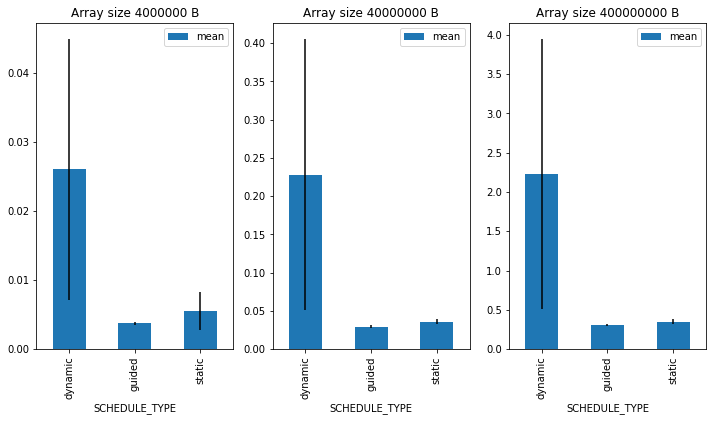

In [73]:
def plot_for_loop_data_without_chunks(agg_data, arr_sizes):
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    for ax, arr_size in zip(axs, arr_sizes):
        heights = agg_data.loc[(arr_size,)]
        heights.plot.bar(y="mean", ax=ax, title=f"Array size {arr_size} B", yerr="std")
    
    plt.show()
    
    
arr_sizes = for_loop_data["ARR_SIZE"].unique()
plot_for_loop_data_without_chunks(aggreg_data_without_chunks, arr_sizes)

Z powyższego wykresu wyraźnie widzimy, że `guided` jest zdecydowanie najlepszym trybem schedule'owania dla przedstawionego problemu. Końcowa implementacja będzie zatem zawierać ten typ schedule'owania jako domyślny.

Zdecydowanie najgorszy okazał się być typ schedule'owania `dynamic`. Było to do przewidzenia, ponieważ w tak prostym problemie jak zapisywanie liczb zmiennoprzecinkowych do tablicy zaawansowany scheduling taki jak `dynamic` nie jest potrzebny.

Sprawdźmy też, jaki jest najlepszy parametr `chunk` dla tego typu.

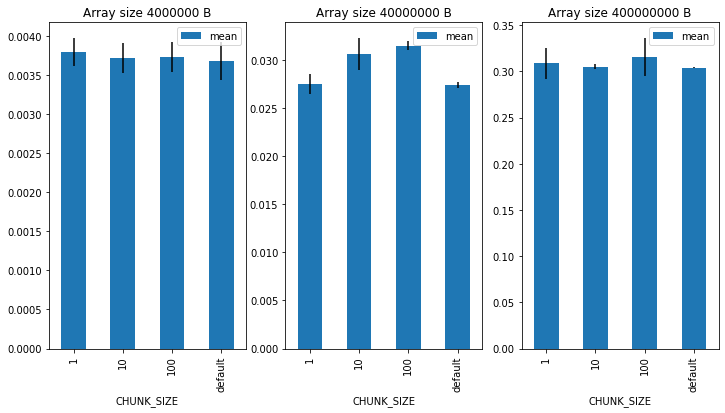

In [76]:
def plot_for_loop_data_with_chunks(agg_data, arr_sizes, schedule_type):
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    for ax, arr_size in zip(axs, arr_sizes):
        heights = agg_data.loc[(arr_size, schedule_type)]
        heights.plot.bar(y="mean", ax=ax, title=f"Array size {arr_size} B", yerr="std")
    
    plt.show()
    
    
arr_sizes = for_loop_data["ARR_SIZE"].unique()
schedule_chunks = for_loop_data["SCHEDULE_TYPE"].unique()
plot_for_loop_data_with_chunks(aggreg_data_with_chunks, arr_sizes, "guided")

Dla każdego zestawu danych najlepszym rozmiarem chunku okazał się być domyślny. Jest to najprawdopodobniej spowodowane najbardziej sprawiedliwym zrównoważeniem wątków.

### Wnioski

Najlepszym trybem schedule'owania dla problemu zapisywania liczb w pętli `for` okazał się być `guided` z domyślnymi parametrami. Powodu można doszukać się w dobrze napisanym przez twórców implementacji load-balancingu dla wielu wątków w przypadku tego schedule'owania. 